# Access Database-Files to explore and summerise Data

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
from tables import *
import sqlite3
import openpyxl as oxl

In [2]:
# aims 
    # plot single data and highlight outliers in data
    # compare epsilon values of different evaluation methods
    # summarise data
    # calculate epsilon values with SSB
    # visulise data for epsilon SSB
    # store summarised data in hd5

In [69]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2015-10-21/data_eval_new/"
file_name = "int_norm_20151021_bgd_new.h5"
path_comp = '/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/'
sum_file = "int_norm_comp_new.h5"

In [70]:
hdf5_file = pd.HDFStore(path+file_name)
#hdf5_sum_file = pd.HDFStore(path_comp+sum_file)

# Methods for Outlier rejection, Summarise and SSB Calculation

In [71]:
def mad_based_outlier(points, thresh=3.5):
        """
        Returns a boolean array with True if points are outliers and False
        otherwise.

        Parameters:
        -----------
            points : An numobservations by numdimensions array of observations
            thresh : The modified z-score to use as a threshold. Observations with
                a modified z-score (based on the median absolute deviation) greater
                than this value will be classified as outliers.

        Returns:
        --------
            mask : A numobservations-length boolean array.

        References:
        ----------
            Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
            Handle Outliers", The ASQC Basic References in Quality Control:
            Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
        """
        if len(points.shape) == 1:
            points = points[:,None]
        median = np.median(points, axis=0)
        diff = np.sum((points - median)**2, axis=-1)
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)

        modified_z_score = 0.6745 * diff / med_abs_deviation

        return modified_z_score > thresh

#outlier rejection
def mad_outlier_rejection(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(~mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Cycle", "Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Cycle"] = df["Cycle"]
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier_mean(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def SE(x):
    SE = np.std(x) / x.count()
    return SE

def SD2(x):
    SD2 = np.nanstd(x, ddof=1) * 2
    return SD2

def df_mean(df):
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).mean()
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    columns = ["Filenumber", "Sample"]
    columns.extend(df.drop(["Filenumber", "Sample"], axis=1).columns)
    df = pd.DataFrame(df, columns = columns)
    
    return df
    
def df_SD(df):    
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).agg([np.mean, SD2])
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    
    return df

def SSB(df, std, multi_fac):
    ### calculate Standard-Sample Bracketing ###

    # bracketing standard #
    std_used = std
    df_to_use = df
    # determine at which position the samples are which are bracketed
    sub_index = df_to_use[(df_to_use["Sample"].shift(1) == df_to_use["Sample"].shift(-1)) & (df_to_use["Sample"].shift(1) == std_used)].index
    # remove measurements with values below 0.1V
    corr_values = df_to_use
    # extract only standard data
    corr_values_2 = df_to_use[df_to_use["Sample"] == std_used]

    # save sample names
    sample = corr_values["Sample"]
    sample_2 = corr_values_2["Sample"]

    # remove sample names from dataframe for calculation
    new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]
    new_2 = corr_values_2[corr_values_2.columns[corr_values_2.dtypes != 'object']]

    # calculate bracketing 
    epsilon_NIST =  ((new / ((new.shift(1) + new.shift(-1))/2))-1)*multi_fac
    epsilon_2 = ((new_2 / ((new_2.shift(1) + new_2.shift(-1))/2))-1)*multi_fac
    # reinsert samples names
    epsilon_NIST["Sample"] = sample
    epsilon_2["Sample"] = sample_2

    # select samples by bracketing index
    epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
    #epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"].str.contains("opt")]
    # select only bracketed sample measurements in dataframe
    epsilon_NIST= epsilon_NIST[epsilon_NIST["Sample"] != std_used]
    # select only bracketed standard measurements in dataframe
    epsilon_2 = epsilon_2[epsilon_2["Sample"] == std_used]
    # append bracketed sample and standard measurements
    epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=False)
    # sort dataframe by datetime
    epsilon_comp = epsilon_comp.sort_index(axis=0)
    
    return epsilon_comp

def plot_epsilon(df, sel_ratio, std, xlim):
    x = range(1, len(epsilon_sum.index)+1)
    plt.errorbar(epsilon_sum[sel_ratio]["mean"], x, xerr = epsilon_sum[sel_ratio]["SD2"], ls='none', marker="o")
    plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
    plt.xlim(xlim)
    plt.ylim([0.5, len(epsilon_sum.index)+1])
    plt.yticks(x, epsilon_sum.index, size='small', rotation=0)
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
    plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
    #savefig(path+"epsilon_118.pdf", bbox_inches='tight')

# Datafiles in Database

In [72]:
hdf5_file.keys()

['/raw_data/baselines',
 '/raw_data/signals_raw',
 '/raw_data/signals_zero',
 '/evaluation/bgd_outlier_corr/df_bgd_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118_120/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118

# Plot raw data and check measurement

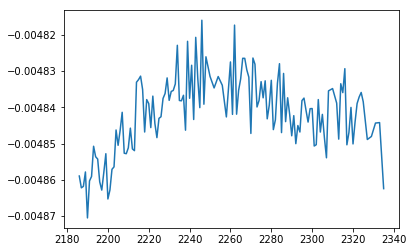

In [73]:
# Check Baselines
column = "116"

baseline = hdf5_file['/raw_data/baselines']
#baseline = baseline[baseline["Filenumber"] == 8979]
plt.plot(baseline["Filenumber"], baseline[column])
plt.show()

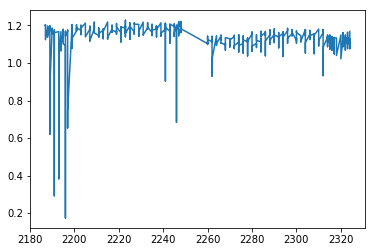

In [74]:
# Check Signals
column = "122"
sample = "NIST 100ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_sub = signals[signals["Sample"] == sample]
plt.plot(signals_sub["Filenumber"], signals_sub[column])
plt.show()

In [75]:
df_mean(signals[signals["122"] < 1])["Sample"]

Date
2015-10-21 18:36:00       blank sol
2015-10-21 19:10:00     NIST 100ppb
2015-10-21 19:34:00     NIST 100ppb
2015-10-21 19:46:00       blank sol
2015-10-21 19:56:00     NIST 100ppb
2015-10-21 20:37:00     NIST 100ppb
2015-10-21 20:49:00     NIST 100ppb
2015-10-21 21:01:00       blank sol
2015-10-21 22:11:00       blank sol
2015-10-21 23:21:00       blank sol
2015-10-22 00:31:00       blank sol
2015-10-22 01:41:00       blank sol
2015-10-22 02:51:00       blank sol
2015-10-22 04:01:00       blank sol
2015-10-22 05:11:00       blank sol
2015-10-22 05:20:00     NIST 100ppb
2015-10-22 05:56:00       blank sol
2015-10-22 06:18:00     NIST 100ppb
2015-10-22 07:06:00       blank sol
2015-10-22 08:17:00       blank sol
2015-10-22 09:18:00       blank sol
2015-10-22 09:27:00     NIST 100ppb
2015-10-22 10:28:00       blank sol
2015-10-22 11:38:00       blank sol
2015-10-22 12:47:00       blank sol
2015-10-22 13:57:00       blank sol
2015-10-22 15:06:00       blank sol
2015-10-22 16:17:00    

In [76]:
df_mean(signals[signals["Sample"] != "blank sol"])["Sample"].unique()

array(['NIST 100ppb', 'NIST 100ppb + Te 0.2ppb',
       'NIST 100ppb + Cd 0.03ppb', 'NIST 100ppb + U 0.003ppb',
       'NIST 100ppb + Te 0.5ppb', 'NIST 100ppb + Cd 0.05ppb',
       'NIST 100ppb + U 0.005ppb', 'NIST 100ppb + Te 1ppb',
       'NIST 100ppb + Cd 0.07ppb', 'NIST 100ppb + U 0.01ppb',
       'NIST 100ppb + Te 2ppb', 'NIST 100ppb + Cd 0.1ppb',
       'NIST 100ppb + U 0.03ppb', 'NIST 100ppb + Te 4ppb',
       'NIST 100ppb + Cd 0.15ppb', 'NIST 100ppb + Te 8ppb', 'SPEX1 100ppb'], dtype=object)

In [77]:
# Renaming samples as the AS position was different to there actual position

signals["Sample"].replace('NIST 100ppb + U 0.01ppb', 'SPEX1 100ppb', inplace = True)
signals["Sample"].replace('NIST 100ppb + U 0.005ppb', 'NIST 100ppb + U 0.01ppb', inplace = True)
signals["Sample"].replace('NIST 100ppb + U 0.003ppb', 'NIST 100ppb + U 0.005ppb', inplace = True)

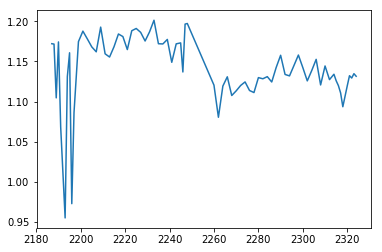

In [78]:
# Check Signals - mean
column = "122"
sample = "NIST 100ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_mean = df_mean(signals)
signals_sub_mean = signals_mean[signals_mean["Sample"] == sample]
plt.plot(signals_sub_mean["Filenumber"], signals_sub_mean[column])
plt.show()

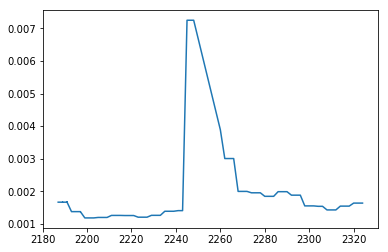

In [79]:
# Check background 
column = "118"
sample = "NIST 100ppb"

background = hdf5_file['/evaluation/bgd_outlier_corr/df_bgd_corr']
background_sub = background[background["Sample"] == sample]
plt.plot(background_sub["Filenumber"], background_sub[column])
plt.show()

In [80]:
background_mean = df_mean(background)

In [81]:
# Create Dataframe for signals_bgd corr
signals["Te/Sn"] = (signals["125_2"]/7.050686)/(signals["118"]/24.223)
signals["Cd/Sn"] = (signals["111"]/12.9447)/(signals["118"]/24.223)

In [82]:
signals_mean = signals.groupby("Filenumber").agg("mean")

# Outlier rejection

In [179]:
bgd_method = 'bgd_outlier_corr' #'no_bgd_corr'
norm_ratio = "r_122_118"
interf_corr = "Te125_Xe129_corr"

In [180]:
df_all_raw_rat = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_raw_ratios_af_interf_corr']
df_mean_int_corr = df_mean(hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_amount_interf_corr'])
df_all = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_internal_norm']

In [184]:
column = "124/118"
sample = "NIST 100ppb"

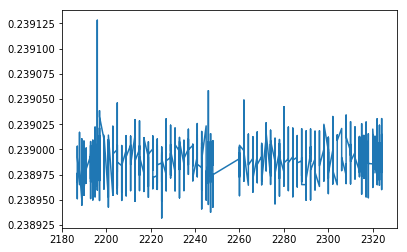

In [185]:
# Check ratios for bracketing standard

df_all_sub = df_all[df_all["Sample"] == sample]
plt.plot(df_all_sub["Filenumber"], df_all_sub[column])
plt.show()

In [186]:
# Renaming samples as the AS position was different to there actual position
df_all["Sample"].replace('NIST 100ppb + U 0.01ppb', 'SPEX1 100ppb', inplace = True)
df_all["Sample"].replace('NIST 100ppb + U 0.005ppb', 'NIST 100ppb + U 0.01ppb', inplace = True)
df_all["Sample"].replace('NIST 100ppb + U 0.003ppb', 'NIST 100ppb + U 0.005ppb', inplace = True)

In [187]:
df_outlier_rej_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier)

df_outlier_rej_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in divide


In [188]:
df_outlier_rej_int

,Sample,Num_of_Ana_Cyc,Cycle,Filenumber,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118
Date,,,,,,,,,,,,,
2015-10-21 18:45:00,NIST 100ppb,2,1,2187,0.040147,0.027181,0.013948,0.600335,0.316742,0.354614,1.345900,NaN,0.238968
2015-10-21 18:45:00,NIST 100ppb,2,2,2187,0.040158,0.027191,0.013947,0.600357,0.316745,0.354620,1.346033,0.19125,0.238976
2015-10-21 18:45:00,NIST 100ppb,2,3,2187,0.040156,0.027194,0.013951,0.600369,0.316724,0.354595,1.345943,NaN,0.238951
2015-10-21 18:45:00,NIST 100ppb,2,4,2187,0.040148,0.027189,0.013948,0.600380,0.316716,0.354613,1.345958,NaN,0.238957
2015-10-21 18:45:00,NIST 100ppb,2,5,2187,0.040148,0.027173,0.013943,0.600339,0.316724,0.354634,1.346000,0.19125,0.238972
2015-10-21 18:45:00,NIST 100ppb,2,6,2187,0.040150,0.027177,0.013943,0.600326,0.316712,0.354637,1.346003,0.19125,0.238986
2015-10-21 18:45:00,NIST 100ppb,2,7,2187,0.040158,0.027187,0.013947,0.600345,0.316710,0.354608,1.345984,NaN,0.238984
2015-10-21 18:45:00,NIST 100ppb,2,8,2187,0.040143,0.027178,0.013947,0.600320,0.316714,0.354627,1.346044,NaN,0.238993
2015-10-21 18:45:00,NIST 100ppb,2,9,2187,0.040142,0.027181,0.013944,0.600318,0.316701,0.354614,1.346009,NaN,0.239001


In [189]:
df_outlier_int[df_outlier_int[column].notnull()][column]

Filenumber  Date               
2196        2015-10-21 20:37:00    0.239128
2208        2015-10-21 22:57:00    0.238932
2213        2015-10-21 23:55:00    0.239030
            2015-10-21 23:55:00    0.238949
2224        2015-10-22 02:02:00    0.239042
2225        2015-10-22 02:15:00    0.238932
2227        2015-10-22 02:39:00    0.239030
2230        2015-10-22 03:12:00    0.238938
2233        2015-10-22 03:49:00    0.238952
2246        2015-10-22 06:18:00    0.239058
2276        2015-10-22 12:11:00    0.238946
2280        2015-10-22 12:57:00    0.239042
2288        2015-10-22 14:30:00    0.239021
2292        2015-10-22 15:16:00    0.238950
2294        2015-10-22 15:40:00    0.239016
            2015-10-22 15:40:00    0.239018
2331        2015-10-22 23:18:00    0.238952
Name: 124/118, dtype: float64

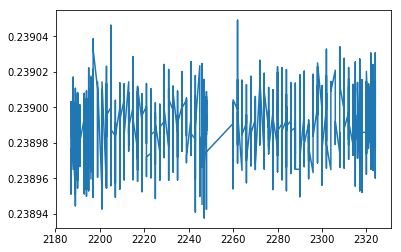

In [190]:
# Check sample measurements
df = df_outlier_rej_int

df_sub = df[df["Sample"] == sample]
plt.plot(df_sub["Filenumber"], df_sub[column])
plt.show()

In [191]:
df[df["Sample"] == sample][column].std()

1.59003790210002e-05

In [192]:
df_outlier_rej_int["Cd/Sn"] = signals[(signals["Sample"] != "blank sol") & (signals["Sample"] != "SQ")]["Cd/Sn"]
df_outlier_rej_int["Te/Sn"] = signals[(signals["Sample"] != "blank sol") & (signals["Sample"] != "SQ")]["Te/Sn"]

In [193]:
data_mean_int = df_mean(df_outlier_rej_int)
data_mean_int_sd = df_SD(df_outlier_rej_int)

data_mean_raw = df_mean(df_outlier_rej_raw)
data_mean_raw_sd = df_SD(df_outlier_rej_raw)

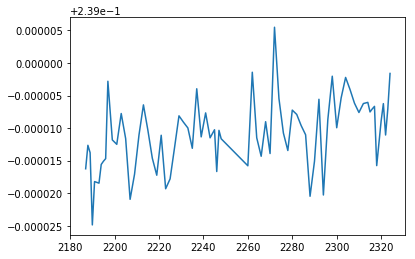

In [194]:
# Check sample measurements
df_mean_used = data_mean_int

df_mean_sub = df_mean_used[df_mean_used["Sample"] == sample]
plt.plot(df_mean_sub["Filenumber"], df_mean_sub[column])
plt.show()

In [195]:
data_mean_int

,Filenumber,Sample,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118,Cd/Sn,Te/Sn
Date,,,,,,,,,,,,,
2015-10-21 18:45:00,2187,NIST 100ppb,0.040148,0.027183,0.013948,0.600334,0.316721,0.354617,1.346006,0.19125,0.238984,0.000021,0.000047
2015-10-21 18:58:00,2188,NIST 100ppb,0.040140,0.027177,0.013949,0.600328,0.316718,0.354611,1.346014,0.19125,0.238987,0.000026,0.000041
2015-10-21 19:10:00,2189,NIST 100ppb,0.040153,0.027192,0.013948,0.600324,0.316723,0.354618,1.346014,0.19125,0.238986,0.000017,0.000040
2015-10-21 19:22:00,2190,NIST 100ppb,0.040143,0.027178,0.013946,0.600328,0.316723,0.354612,1.346015,0.19125,0.238975,0.000025,0.000046
2015-10-21 19:34:00,2191,NIST 100ppb,0.040152,0.027192,0.013948,0.600327,0.316718,0.354616,1.346002,0.19125,0.238982,0.000019,0.000050
2015-10-21 19:56:00,2193,NIST 100ppb,0.040151,0.027183,0.013947,0.600331,0.316723,0.354603,1.345997,0.19125,0.238982,0.000021,0.000060
2015-10-21 20:08:00,2194,NIST 100ppb,0.040145,0.027182,0.013946,0.600326,0.316720,0.354610,1.346003,0.19125,0.238984,0.000023,0.000047
2015-10-21 20:25:00,2195,NIST 100ppb,0.040145,0.027179,0.013949,0.600325,0.316727,0.354615,1.346019,0.19125,0.238985,0.000025,0.000057
2015-10-21 20:37:00,2196,NIST 100ppb,0.040148,0.027183,0.013946,0.600335,0.316722,0.354614,1.346007,0.19125,0.238985,0.000020,0.000080


In [196]:
date_list = []
                         
data_mean_raw = data_mean_raw.drop(date_list)
data_mean_int = data_mean_int.drop(date_list)
data_mean_raw_sd = data_mean_raw_sd.drop(date_list)
data_mean_int_sd = data_mean_int_sd.drop(date_list)

In [197]:
drop_sum = [pd.Timestamp("2015-10-21 18:45:00"), 
             pd.Timestamp("2015-10-21 18:58:00"), 
             pd.Timestamp("2015-10-21 19:10:00"),
             pd.Timestamp("2015-10-21 19:22:00"), 
             pd.Timestamp("2015-10-21 19:34:00"), 
             pd.Timestamp("2015-10-21 19:56:00")]

In [198]:

data_mean_int_sum = data_mean_int.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_int_sum = data_mean_int_sum.drop("Filenumber", axis=1)

In [199]:
data_mean_raw_sum = data_mean_raw.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_raw_sum = data_mean_raw_sum.drop("Filenumber", axis=1)

In [200]:
data_mean_int_sum

112/118                       114/118            \
                              mean           SD2 count      mean       SD2   
Sample                                                                       
NIST 100ppb               0.040146  6.655096e-06    68  0.027185  0.000007   
NIST 100ppb + Cd 0.03ppb  0.040147  6.333048e-06     3  0.027190  0.000006   
NIST 100ppb + Cd 0.05ppb  0.040148  3.041811e-07     2  0.027192  0.000004   
NIST 100ppb + Cd 0.07ppb  0.040149  1.217275e-05     2  0.027193  0.000014   
NIST 100ppb + Cd 0.15ppb  0.040155  9.646610e-07     2  0.027202  0.000004   
NIST 100ppb + Cd 0.1ppb   0.040148  4.016565e-06     2  0.027193  0.000009   
NIST 100ppb + Te 0.2ppb   0.040145  7.597543e-06     3  0.027186  0.000011   
NIST 100ppb + Te 0.5ppb   0.040147  4.353170e-06     2  0.027185  0.000002   
NIST 100ppb + Te 1ppb     0.040146  3.438840e-06     2  0.027187  0.000002   
NIST 100ppb + Te 2ppb     0.040147  1.400491e-05     2  0.027182  0.000001   
NIST 100ppb + Te 4ppb     0.040146  1.143439e-05     2  0.027185  0.000010   
NIST 100ppb + Te 8ppb     0.040144  1.701787e-06     2  0.027183  0.000005   
NIST 100ppb + U 0.01ppb   0.040146  7.044746e-06     3  0.027184  0.000005   
NIST 100ppb + U 0.03ppb   0.040152  3.634223e-06     2  0.027188  0.000012   
SPEX1 100ppb              0.040146  5.686001e-06     8  0.027184  0.000009   

                                 115/118                       116/118  ...   \
                         count      mean           SD2 count      mean  ...    
Sample                                                                  ...    
NIST 100ppb                 68  0.013948  3.847475e-06    68  0.600330  ...    
NIST 100ppb + Cd 0.03ppb     3  0.013948  6.731859e-06     3  0.600334  ...    
NIST 100ppb + Cd 0.05ppb     2  0.013949  9.144375e-06     2  0.600339  ...    
NIST 100ppb + Cd 0.07ppb     2  0.013949  9.885025e-07     2  0.600343  ...    
NIST 100ppb + Cd 0.15ppb     2  0.013948  6.534907e-06     2  0.600344  ...    
NIST 100ppb + Cd 0.1ppb      2  0.013949  6.745848e-06     2  0.600347  ...    
NIST 100ppb + Te 0.2ppb      3  0.013948  1.514367e-06     3  0.600332  ...    
NIST 100ppb + Te 0.5ppb      2  0.013945  2.943348e-06     2  0.600330  ...    
NIST 100ppb + Te 1ppb        2  0.013948  1.579039e-06     2  0.600339  ...    
NIST 100ppb + Te 2ppb        2  0.013949  4.430729e-06     2  0.600333  ...    
NIST 100ppb + Te 4ppb        2  0.013947  2.235914e-06     2  0.600332  ...    
NIST 100ppb + Te 8ppb        2  0.013947  1.949275e-06     2  0.600320  ...    
NIST 100ppb + U 0.01ppb      3  0.013946  2.602395e-06     3  0.600332  ...    
NIST 100ppb + U 0.03ppb      2  0.013947  3.282257e-06     2  0.600337  ...    
SPEX1 100ppb                 8  0.013955  1.036918e-05     8  0.600323  ...    

                         122/118   124/118                         Cd/Sn  \
                           count      mean           SD2 count      mean   
Sample                                                                     
NIST 100ppb                   68  0.238990  1.022003e-05    68  0.000020   
NIST 100ppb + Cd 0.03ppb       3  0.238986  1.092005e-05     3  0.000118   
NIST 100ppb + Cd 0.05ppb       2  0.238992  8.048282e-06     2  0.000184   
NIST 100ppb + Cd 0.07ppb       2  0.238987  9.560097e-06     2  0.000249   
NIST 100ppb + Cd 0.15ppb       2  0.238989  1.053157e-06     2  0.000509   
NIST 100ppb + Cd 0.1ppb        2  0.238991  2.817464e-06     2  0.000347   
NIST 100ppb + Te 0.2ppb        3  0.238986  1.472266e-05     3  0.000024   
NIST 100ppb + Te 0.5ppb        2  0.238988  3.815975e-06     2  0.000022   
NIST 100ppb + Te 1ppb          2  0.238989  5.377324e-06     2  0.000018   
NIST 100ppb + Te 2ppb          2  0.238989  1.046266e-06     2  0.000018   
NIST 100ppb + Te 4ppb          2  0.238993  5.742361e-07     2  0.000019   
NIST 100ppb + Te 8ppb          2  0.239006  2.228382e-06     2  0.000019   
NIST 100ppb + U 0.01ppb        3  0.23898

In [201]:
date_list = [pd.Timestamp("2015-10-21 18:45:00"), 
             pd.Timestamp("2015-10-21 18:58:00"), 
             pd.Timestamp("2015-10-21 19:10:00"),
             pd.Timestamp("2015-10-21 19:22:00"), 
             pd.Timestamp("2015-10-21 19:34:00"), 
             pd.Timestamp("2015-10-21 19:56:00"),
             pd.Timestamp("2015-10-22 03:25:00"),
             pd.Timestamp("2015-10-22 14:54:00"), 
             pd.Timestamp("2015-10-22 18:42:00"), 
             pd.Timestamp("2015-10-22 21:19:00")]

epsilon_int_NIST = SSB(data_mean_int.drop(date_list), "NIST 100ppb", 10000)
delta_raw_NIST = SSB(data_mean_raw.drop(date_list), "NIST 100ppb", 1000)

In [202]:
epsilon_int_NIST = epsilon_int_NIST.drop(["Cd/Sn", "Te/Sn"], axis=1)

In [203]:
epsilon_int_NIST[epsilon_int_NIST["Filenumber"] > 1]

,Filenumber,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118,Sample
Date,,,,,,,,,,,
2015-10-22 03:49:00,4.480287,0.812587,1.583567,1.619756,0.078308,0.174738,-0.134246,-0.030585,-1.110223e-12,0.026426,NIST 100ppb
2015-10-22 06:06:00,2.227668,0.763220,0.919491,1.024491,0.173910,0.249400,0.112955,-0.022479,-1.110223e-12,0.160313,NIST 100ppb
2015-10-22 09:06:00,22.172949,0.522091,0.449324,-0.420204,0.074685,-0.155763,-0.143129,-0.023934,-1.110223e-12,-0.387604,NIST 100ppb
2015-10-22 15:16:00,4.364906,0.992715,0.084477,0.469075,-0.194359,-0.290347,0.031899,0.089837,4.440892e-12,0.619703,NIST 100ppb
2015-10-22 19:36:00,4.327131,0.775758,0.869848,0.258522,-0.253688,-0.166460,0.093609,0.064397,0.000000e+00,-0.004897,NIST 100ppb
2015-10-22 19:57:00,2.161228,-0.312086,-0.312037,1.578946,0.012131,0.118796,-0.037059,-0.069883,-1.110223e-12,0.034552,NIST 100ppb
2015-10-22 21:31:00,2.153780,0.923900,0.488258,0.499319,0.205307,0.064942,-0.055144,-0.082928,2.220446e-12,-0.129237,NIST 100ppb


In [204]:

date_list = []

epsilon_int_NIST = epsilon_int_NIST.drop(date_list)
delta_raw_NIST = delta_raw_NIST.drop(date_list)

In [205]:
def epsilon_process(df):
    df = df[(df["Filenumber"] >= -5) & (df["Filenumber"] <= 5)]
    df["Filenumber"] = data_mean_int["Filenumber"].ix[df.index]
    return df

In [206]:
epsilon_int_NIST = epsilon_process(epsilon_int_NIST)
delta_raw_NIST = epsilon_process(delta_raw_NIST)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [207]:
epsilon_int_NIST[(epsilon_int_NIST["112/120"] > 1) | (epsilon_int_NIST["112/120"] < -1)]

KeyError: '112/120'

In [208]:
epsilon_NIST_sum = np.round(epsilon_int_NIST.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_NIST_sum = np.round(delta_raw_NIST.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)

epsilon_sum_all = epsilon_NIST_sum
epsilon_sum_all = epsilon_sum_all.drop("Filenumber", axis=1)
delta_raw_sum_all = delta_raw_NIST_sum
delta_raw_sum_all = delta_raw_sum_all.drop("Filenumber", axis=1)

In [209]:
epsilon_sum_all

112/118              114/118              115/118  \
                            mean    SD2 count    mean    SD2 count    mean   
Sample                                                                       
NIST 100ppb               -0.014  1.472    60  -0.031  2.379    60   0.003   
NIST 100ppb + Cd 0.03ppb   0.677  0.147     2   1.450  0.877     2  -0.350   
NIST 100ppb + Cd 0.05ppb   0.160  0.072     2   2.158  0.184     2   0.429   
NIST 100ppb + Cd 0.07ppb   0.341  2.955     2   2.633  2.355     2   0.935   
NIST 100ppb + Cd 0.15ppb   2.614  0.552     2   7.450  0.265     2   0.637   
NIST 100ppb + Cd 0.1ppb   -0.575    NaN     1   2.991    NaN     1   2.463   
NIST 100ppb + Te 0.2ppb    0.649  0.220     2   1.452  1.378     2   0.409   
NIST 100ppb + Te 0.5ppb    0.895  0.720     2   0.489  1.376     2  -1.123   
NIST 100ppb + Te 1ppb     -0.137  0.288     2   0.755  3.478     2   0.033   
NIST 100ppb + Te 2ppb     -0.608  2.876     2  -0.911  1.196     2  -0.296   
NIST 100ppb + Te 4ppb      0.108  3.043     2   0.599  3.122     2  -0.171   
NIST 100ppb + Te 8ppb     -0.586  1.621     2  -1.624  2.044     2   0.369   
NIST 100ppb + U 0.01ppb    0.783  1.688     2  -0.353  0.532     2  -0.566   
NIST 100ppb + U 0.03ppb    0.361    NaN     1  -0.049    NaN     1  -2.012   
SPEX1 100ppb              -0.834  2.532     4  -2.141  2.433     4   3.180   

                                      116/118  ...  119/118 120/118         \
                            SD2 count    mean  ...    count    mean    SD2   
Sample                                         ...                           
NIST 100ppb               3.101    60   0.000  ...       60   0.001  0.143   
NIST 100ppb + Cd 0.03ppb  3.241     2   0.033  ...        2  -0.019  0.079   
NIST 100ppb + Cd 0.05ppb  5.926     2   0.101  ...        2   0.008  0.102   
NIST 100ppb + Cd 0.07ppb  1.726     2   0.151  ...        2  -0.063  0.134   
NIST 100ppb + Cd 0.15ppb  4.193     2   0.240  ...        2  -0.013  0.156   
NIST 100ppb + Cd 0.1ppb     NaN     1   0.133  ...        1   0.100    NaN   
NIST 100ppb + Te 0.2ppb   0.259     2   0.075  ...        2  -0.001  0.176   
NIST 100ppb + Te 0.5ppb   4.611     2  -0.030  ...        2   0.017  0.281   
NIST 100ppb + Te 1ppb     0.988     2   0.044  ...        2  -0.040  0.114   
NIST 100ppb + Te 2ppb     2.447     2  -0.092  ...        2   0.060  0.052   
NIST 100ppb + Te 4ppb     1.617     2   0.002  ...        2   0.025  0.241   
NIST 100ppb + Te 8ppb     1.089     2  -0.114  ...        2   0.212  0.198   
NIST 100ppb + U 0.01ppb   0.102     2   0.041  ...        2  -0.091  0.000   
NIST 100ppb + U 0.03ppb     NaN     1  -0.220  ...        1   0.052    NaN   
SPEX1 100ppb              8.168     4  -0.159  ...        4   0.048  0.058   

                               122/118            124/118               
                         count    mean  SD2 count    mean    SD2 count  
Sample                                                                  
NIST 100ppb                 60     0.0  0.0    60   0.004  0.487    60  
NIST 100ppb + Cd 0.03ppb     2     0.0  0.0     2   0.014  0.271     2  
NIST 100ppb + Cd 0.05ppb     2     0.0  0.0     2   0.022  0.374     2  
NIST 100ppb + Cd 0.07ppb     2     0.0  0.0     2  -0.064  0.720     2  
NIST 100ppb + Cd 0.15ppb     2    -0.0  0.0     2  -0.155  0.044     2  
NIST 100ppb + Cd 0.1ppb      1    -0.0  NaN     1   0.196    NaN     1  
NIST 100ppb + Te 0.2ppb      2     0.0  0.0     2  -0.201  0.534     2  
NIST 100ppb + Te 0.5ppb      2     0.0  0.0     2  -0.003  1.036     2  
NIST 100ppb + Te 1ppb        2     0.0  0.0     2   0.050  0.270     2  
NIST 100ppb + Te 2ppb        2    -0.0  0.0     2   0.153  0.097     2  
NIST 100ppb + Te 4ppb        2    -0.0  0.0     2   0.000  0.175     2  
NIST 100ppb + Te 8ppb        2    -0.0  0.0     2   0.505  0.288     2  
NIST 100ppb + U 0.01ppb      2    -0.0  0.0     2  -0.069  0.439     2  
NIST 100ppb + U 0.03ppb      1     0.0  NaN    

In [210]:
delta_raw_sum_all

112/118              114/118              115/118  \
                            mean    SD2 count    mean    SD2 count    mean   
Sample                                                                       
NIST 100ppb                0.006  0.467    62   0.004  0.339    62   0.005   
NIST 100ppb + Cd 0.03ppb   0.177  0.363     2   0.198  0.393     2   0.021   
NIST 100ppb + Cd 0.05ppb  -0.083  0.021     2   0.171  0.087     2  -0.004   
NIST 100ppb + Cd 0.07ppb  -0.100  0.559     2   0.162  0.374     2   0.032   
NIST 100ppb + Cd 0.15ppb   0.146  0.157     2   0.648  0.100     2  -0.000   
NIST 100ppb + Cd 0.1ppb   -0.344    NaN     1   0.122    NaN     1   0.129   
NIST 100ppb + Te 0.2ppb    0.223  0.390     2   0.245  0.136     2   0.124   
NIST 100ppb + Te 0.5ppb    0.073  0.313     2   0.023  0.285     2  -0.124   
NIST 100ppb + Te 1ppb      0.082  0.589     2   0.127  0.013     2   0.032   
NIST 100ppb + Te 2ppb     -0.172  0.388     2  -0.160  0.067     2  -0.103   
NIST 100ppb + Te 4ppb      0.078  0.476     2   0.100  0.439     2   0.013   
NIST 100ppb + Te 8ppb     -0.165  0.214     2  -0.214  0.091     2  -0.024   
NIST 100ppb + U 0.003ppb  -0.110  0.487     2  -0.153  0.137     2  -0.151   
NIST 100ppb + U 0.005ppb   0.167  0.307     2  -0.024  0.025     2   0.038   
NIST 100ppb + U 0.01ppb   -0.757  0.026     2  -0.696  0.213     2   0.369   
NIST 100ppb + U 0.03ppb    0.328    NaN     1   0.160    NaN     1  -0.053   

                                      116/118  ...  119/118 120/118         \
                            SD2 count    mean  ...    count    mean    SD2   
Sample                                         ...                           
NIST 100ppb               0.380    62   0.002  ...       62  -0.002  0.146   
NIST 100ppb + Cd 0.03ppb  0.144     2   0.048  ...        2  -0.037  0.109   
NIST 100ppb + Cd 0.05ppb  0.580     2  -0.022  ...        2   0.036  0.028   
NIST 100ppb + Cd 0.07ppb  0.116     2  -0.029  ...        2   0.035  0.095   
NIST 100ppb + Cd 0.15ppb  0.349     2  -0.018  ...        2   0.042  0.019   
NIST 100ppb + Cd 0.1ppb     NaN     1  -0.087  ...        1   0.089    NaN   
NIST 100ppb + Te 0.2ppb   0.203     2   0.134  ...        2  -0.072  0.180   
NIST 100ppb + Te 0.5ppb   0.568     2  -0.021  ...        2   0.020  0.066   
NIST 100ppb + Te 1ppb     0.126     2   0.035  ...        2  -0.035  0.193   
NIST 100ppb + Te 2ppb     0.214     2  -0.046  ...        2   0.039  0.020   
NIST 100ppb + Te 4ppb     0.067     2   0.019  ...        2  -0.010  0.020   
NIST 100ppb + Te 8ppb     0.317     2  -0.055  ...        2   0.062  0.160   
NIST 100ppb + U 0.003ppb  0.152     2  -0.056  ...        2   0.048  0.105   
NIST 100ppb + U 0.005ppb  0.060     2   0.042  ...        2  -0.039  0.073   
NIST 100ppb + U 0.01ppb   0.122     2  -0.219  ...        2   0.186  0.040   
NIST 100ppb + U 0.03ppb     NaN     1   0.070  ...        1  -0.095    NaN   

                               122/118              124/118               
                         count    mean    SD2 count    mean    SD2 count  
Sample                                                                    
NIST 100ppb                 62  -0.004  0.297    62  -0.006  0.438    62  
NIST 100ppb + Cd 0.03ppb     2  -0.077  0.220     2  -0.113  0.302     2  
NIST 100ppb + Cd 0.05ppb     2   0.063  0.009     2   0.099  0.046     2  
NIST 100ppb + Cd 0.07ppb     2   0.081  0.181     2   0.124  0.315     2  
NIST 100ppb + Cd 0.15ppb     2   0.083  0.091     2   0.104  0.128     2  
NIST 100ppb + Cd 0.1ppb      1   0.167    NaN     1   0.252    NaN     1  
NIST 100ppb + Te 0.2ppb      2  -0.246  0.687     2  -0.383  0.993     2  
NIST 100ppb + Te 0.5ppb      2   0.038  0.074     2   0.058  0.174     2  
NIST 100ppb + Te 1ppb        2  -0.066  0.371     2  -0.086  0.560     2  
NIST 100ppb + Te 2ppb        2   0.071  0.064     2   0.115  0.067     2  
NIST 100ppb + Te 4ppb        2  -0.023  0.079     2  -0.046  0.134     2  
NIST 100p

In [199]:
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_int_outlier_corr_all', df_outlier_rej_int, min_itemsize = {"Sample": 50})
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_raw_outlier_corr_all', df_outlier_rej_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_int', data_mean_int, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_raw', data_mean_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int', epsilon_int_SPEX, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_delta_raw', delta_raw_SPEX, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/signals_mean', signals_mean, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/background_mean', background_mean, min_itemsize = {"Sample": 50})

NameError: name 'hdf5_sum_file' is not defined

In [154]:
hdf5_sum_file['/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int']

NameError: name 'hdf5_sum_file' is not defined

# Raw data to xls file

In [63]:
signals_raw = hdf5_file['/raw_data/signals_raw']

In [64]:
writer_raw = pd.ExcelWriter(path+'raw_data.xlsx', engine='xlsxwriter')

baseline.to_excel(writer_raw, index=True, sheet_name='baseline')
signals_raw.to_excel(writer_raw, index=True, sheet_name='signals_raw')
signals.to_excel(writer_raw, index=True, sheet_name='signals_baseline_corr')
background.to_excel(writer_raw, index=True, sheet_name='background')

writer_raw.save()

In [211]:
writer_orig = pd.ExcelWriter(path+ bgd_method + '_'  +norm_ratio + '_' + interf_corr +'_bgd_new.xlsx', engine='xlsxwriter')


In [212]:
df_mean_int_corr.to_excel(writer_orig, index=True, sheet_name='amount_interf_corr_all')
df_all.to_excel(writer_orig, index=True, sheet_name='data_int_norm_all')
df_all_raw_rat.to_excel(writer_orig, index=True, sheet_name='data_raw_ratios_all')
df_outlier_int.to_excel(writer_orig, index=True, sheet_name='data_int_outliers_all')
data_mean_int_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_int_sd')
data_mean_int_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_int_summary')
data_mean_raw_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_sd')
data_mean_raw_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_summary')
epsilon_int_NIST.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SSB')
epsilon_sum_all.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SBB_summary')
delta_raw_NIST.to_excel(writer_orig, index=True, sheet_name='delta_raw_SSB')
delta_raw_sum_all.to_excel(writer_orig, index=True, sheet_name='delta_raw_SBB_summary')

In [213]:
writer_orig.save()

In [111]:
hdf5_sum_file.flush()
hdf5_sum_file.close()

NameError: name 'hdf5_sum_file' is not defined

In [ ]:
# create by plots for selected column
sel_ratio = ["eSn_122_118"]

# defines limits on x-axis
xlim = [-4, 4]

# creates figure
fig = plt.figure(figsize=(10,15))

# iterates over selected ratios and creates plots
for i in range(len(sel_ratio)):
    ax = plt.subplot(5,2,i+1)
    plot_epsilon(sel_ratio[i], "NIST + DS 0.5-0.5", xlim)
fig.tight_layout()
plt.show()
#wb.sheets[4].pictures.add(fig, name= '116/120 norm - bgd_corr 1', update = True)
#fig.savefig(path+"DS_epsilon_x_bgd_122_118_100ppb_mixtures.pdf", bbox_inches='tight')

In [214]:
hdf5_file.flush()
hdf5_file.close()

In [ ]:
# creates a single plot to show mixtures against fspike

std = "NIST + DS 0.5-0.5"
sel_ratio = "eSn_122_118"
sel_var = "fspike"

fig2 = plt.figure(figsize=(10,7))
plt.errorbar(df_DS_inv_mean_sample_sd[df_DS_inv_mean_sample_sd.index.str.contains("NIST")][sel_var]["mean"], epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["mean"] , yerr = epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["SD2"], ls='none', marker="o")
plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
plt.xlim([0, 1])
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
plt.xlabel(sel_var)
plt.show()
#fig2.savefig(path+"DS_epsilon_122_118_fspike_100ppb_mixtures.pdf", bbox_inches='tight')